## UCL COMP0029 Individual Project for Year 3 BSc
### Robust Robotic Grasping Utilising Touch Sensing - Baseline Approach Notebook
This notebook contains the code for developing a baseline approach to grasping using classifiers: given some combinations of tactile data, end effector poses relative to the robot hand (visual data), etc., determine whether these constraints will produce a successful/unsuccessful grasp.

### 1. Load packages

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

Set device for `PyTorch` training

In [91]:
# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Empty PyTorch cache

In [92]:
gc.collect()
torch.cuda.empty_cache()

### 2. Load datasets from saved .npy files

To collect data for this experiment, you can run the "Collect Sensory Data" button in the Pybullet simulation. This generates a predefined number of Gaussian grasps randomly generated from a base hand pose. Each individual grasp is considered as an individual experiment, and the data collected from this experiment is split into four, each stored in its own dataset.

For all object models used in this experiment, each object has 4 datasets which include:
- `depth_ds.npy` which stores the depth tactile data from the mounted DIGIT sensors
- `color_ds.npy` which stores the colored (RGB) version of the depth tactile data from the mounted DIGIT sensors
- `poses_ds.npy` which stores the randomly-generated 6d hand poses from the simulation
- `outcomes_ds.npy` which stores the outcomes of each random pose

In [93]:
object_name = "bottle"      # object_name should be in [bottle, block, mug]

# Construct the relative paths of each dataset and load them into the notebook
depth_ds_file_path = object_name + "_ds/depth_ds.npy"
depth_data = np.load(depth_ds_file_path)

color_ds_file_path = object_name + "_ds/color_ds.npy"
color_data = np.load(color_ds_file_path)

poses_ds_file_path = object_name + "_ds/poses_ds.npy"
poses_data = np.load(poses_ds_file_path)

grasp_outcomes_ds_file_path = object_name + "_ds/grasp_outcomes.npy"
grasp_outcomes_data = np.load(grasp_outcomes_ds_file_path)

These datasets should all be in the form of $(N\times...)$ where $N$ is the number of examples:

In [94]:
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")
print(f"Shape of poses_data: {poses_data.shape}")
print(f"Shape of grasp_outcomes_data: {grasp_outcomes_data.shape}")

Shape of depth_data: (1000, 2, 160, 120)
Shape of color_data: (1000, 2, 160, 120, 3)
Shape of poses_data: (1000, 6)
Shape of grasp_outcomes_data: (1000,)


Additionally, we confirm the number of successful and unsuccessful grasps recorded. This helps us in the next section to determine how many examples we should include for each class in order to produce a balanced dataset.

In [95]:
print(f"# of sucessesful grasps: {(grasp_outcomes_data == 1).sum()}")
print(f"# of unsuccessful grasps: {(grasp_outcomes_data == 0).sum()}")

# of sucessesful grasps: 554
# of unsuccessful grasps: 446


### 3. Data preprocessing

We will train a logistic regression classifier on 3 combinations of data:
- **Tactile** only: concatenated and flattened depth and color data
- **Visual** only: 6D end effector poses consisting of position (x,y,z) and orientation (r,p,y) data
- **Both**: concatenated and flattened tactile and visual data

#### 3a. Sampling
We sample a pre-defined number of examples from each class label (successful and unsuccessful grasps) to reduce the computational cost.

In [96]:
sample_size = 400

In [97]:
# Function to sample n samples from the datasets
def sample_data(depth_data, color_data, poses_data, outcomes_data, no_of_examples):
    d, c, p, o = [], [], [], []
    for label in np.unique(outcomes_data):
        indices = np.where(outcomes_data == label)[0]

        for i in range(no_of_examples):
            d.append(depth_data[indices[i]])
            c.append(color_data[indices[i]])
            p.append(poses_data[indices[i]])
            o.append(outcomes_data[indices[i]])
    
    depth_data = torch.from_numpy(np.array(d))
    color_data = torch.from_numpy(np.array(c))
    poses_data = torch.from_numpy(np.array(p))
    outcomes_data = torch.from_numpy(np.array(o))
    return depth_data, color_data, poses_data, outcomes_data

Sample `sample_size` samples:

In [98]:
depth_data, color_data, poses_data, grasp_outcomes_data = sample_data(depth_data, color_data, poses_data, grasp_outcomes_data, no_of_examples=sample_size)

In [99]:
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")
print(f"Shape of poses_data: {poses_data.shape}")
print(f"Shape of grasp_outcomes_data: {grasp_outcomes_data.shape}")

Shape of depth_data: torch.Size([800, 2, 160, 120])
Shape of color_data: torch.Size([800, 2, 160, 120, 3])
Shape of poses_data: torch.Size([800, 6])
Shape of grasp_outcomes_data: torch.Size([800])


#### 3b. Preprocessing

We define some reusable functions for later:

In [100]:
def normalize(tensor):
    # Normalize & standardize each column
    mean = torch.mean(tensor, axis=0)
    std = torch.std(tensor, axis=0)
    return (tensor - mean) / std


def downsample_2d_tensor(tensor, factor=2):
    return torch.nn.functional.avg_pool2d(tensor.unsqueeze(0), kernel_size=factor, stride=factor, padding=0).squeeze(0)


def downsample_3d_tensor(tensor, factor=2):
    pooling_kernel = 2
    pooling_layer = torch.nn.AvgPool2d(kernel_size=pooling_kernel, stride=pooling_kernel)
    downsampled_tensor = pooling_layer(tensor.permute(0, 3, 1, 2))
    downsampled_tensor = downsampled_tensor.permute(0, 2, 3, 1)
    
    return downsampled_tensor

Since each tactile reading (depth and color) is a pair of images (one on each finger), we concatenate them together as a single 160x240 image.

In [101]:
depth_data = torch.cat([depth_data[:, 0, :, :], depth_data[:, 1, :, :]], dim=2)
color_data = torch.cat([color_data[:, 0, :, :, :], color_data[:, 1, :, :, :]], dim=2)
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")

Shape of depth_data: torch.Size([800, 160, 240])
Shape of color_data: torch.Size([800, 160, 240, 3])


We then concatenate the depth and color datasets to produce the flattened tactile dataset:

In [102]:
# depth_ds = depth_data.reshape(depth_data.shape[0], -1)
# color_ds = color_data.reshape(color_data.shape[0], -1)
# depth_ds.shape,  color_ds.shape

#### 3c. Normalising the datasets

In [103]:
# depth_ds = normalize(depth_ds)
# color_ds = normalize(color_ds)
depth_ds = normalize(depth_data)
color_ds = normalize(color_data)
visual_ds = torch.from_numpy(np.nan_to_num(normalize(poses_data)))
visual_ds

tensor([[-1.2288, -0.6461,  0.6653, -0.8724,  0.8402,  1.6611],
        [-0.0097, -0.1307,  0.9472,  1.1448,  0.5886,  0.1531],
        [ 1.4310,  1.4673, -0.2007, -0.8724,  1.2510,  0.1531],
        ...,
        [-0.0097, -0.2314,  0.1141,  1.1448,  1.8820, -0.3761],
        [ 1.4310,  1.3667, -1.0338, -0.8724,  2.5444, -0.3761],
        [-0.0097,  0.0581, -0.7453,  1.1448, -0.7714, -0.4547]],
       dtype=torch.float64)

Create the tactile dataset and the complete dataset (tactile+visual)

In [104]:
# tactile_ds = torch.cat([depth_ds, color_ds], dim=1)
# complete_ds = torch.cat([tactile_ds, visual_ds], dim=1)
tactile_ds = torch.cat([depth_ds.unsqueeze(-1), color_ds], dim=-1)
complete_ds = torch.cat([tactile_ds.reshape(tactile_ds.shape[0], -1), visual_ds], dim=1)
tactile_ds.shape, complete_ds.shape

(torch.Size([800, 160, 240, 4]), torch.Size([800, 153606]))

### 4. Dataset visualisation (optional)

Only run this section to produce figures and plots for the project report.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

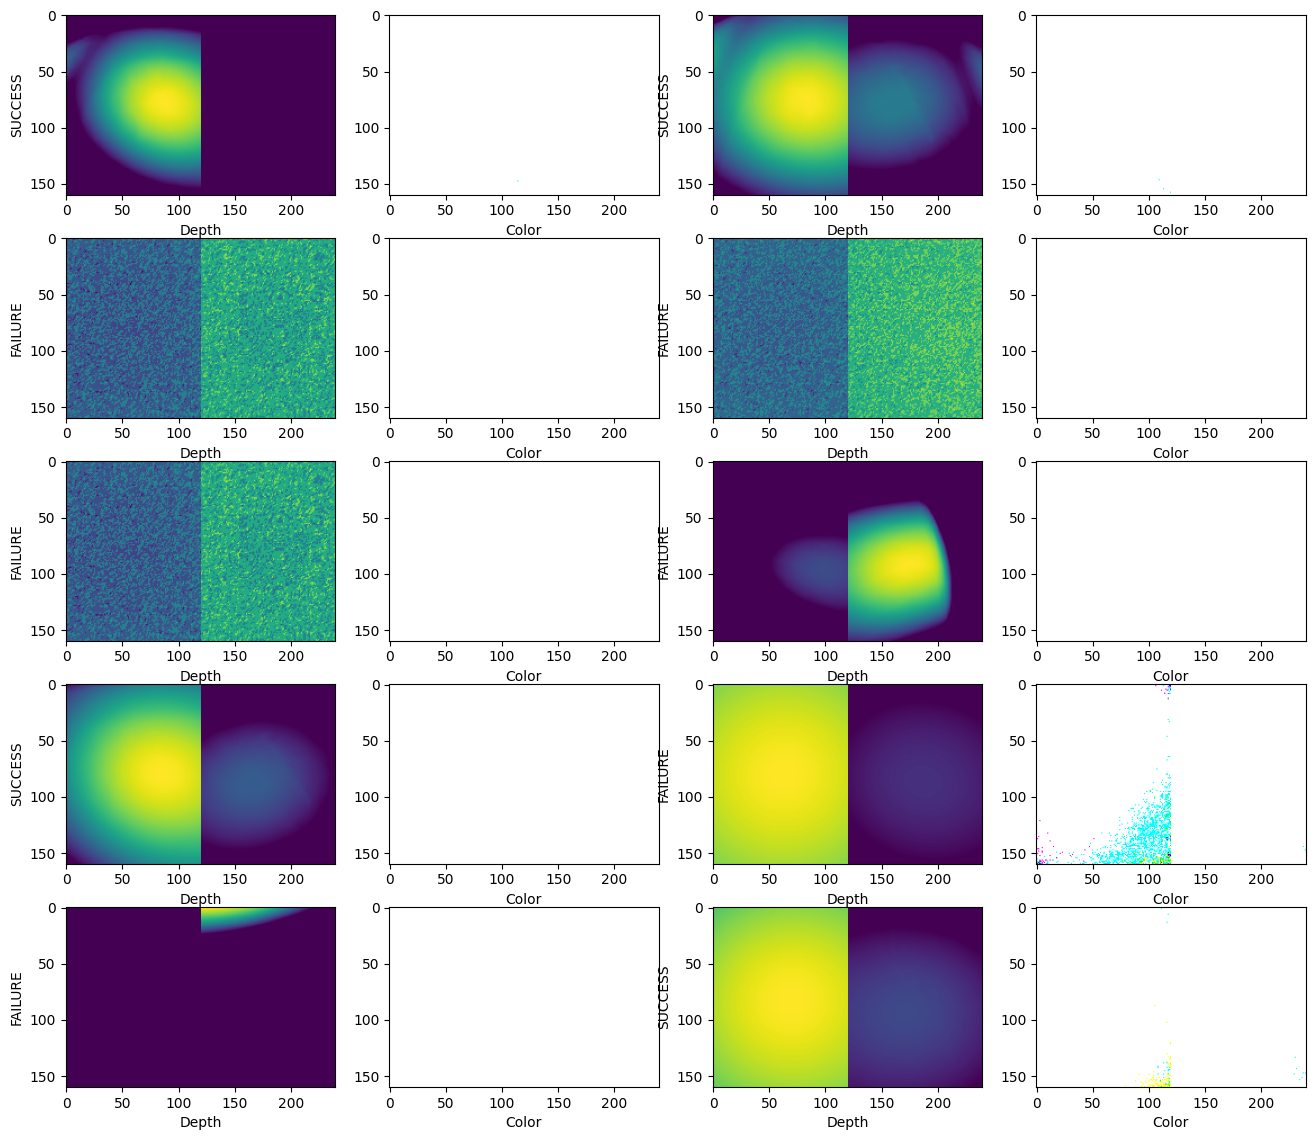

In [105]:
rand_indices = np.random.choice(len(depth_data), size=10)
cols = 4
rows = 5
fig = plt.figure(figsize=(16, 14))

# Note that the plots use the "..._data" datasets instead of the "..._ds" datasets since 
# the "..._ds" datasets are already flattened for training
for i in range(rows*cols):
    fig.add_subplot(rows, cols, i+1)
    if i % 2 == 0:
        plt.xlabel("Depth")
        plt.ylabel("SUCCESS" if grasp_outcomes_data[rand_indices[i//2]].item() == 1.0 else "FAILURE")
        plt.imshow(np.array(depth_data[rand_indices[i//2]]))
    elif i % 2 == 1:
        plt.xlabel("Color")
        plt.imshow(np.array(color_data[rand_indices[i//2]]))
plt.show()

Plot the end effector poses to investigate if we can simply visualise a clear decision boundary between successful & unsuccessful grasps

In [106]:
### Helper function to calculate approach vectors of a 6D pose
def calc_approach_vector(coord):
    R = np.array([[np.cos(coord[5])*np.cos(coord[4]), np.cos(coord[5])*np.sin(coord[4])*np.sin(coord[3])-np.sin(coord[5])*np.cos(coord[3]), np.cos(coord[5])*np.sin(coord[4])*np.cos(coord[3])+np.sin(coord[5])*np.sin(coord[3])],
              [np.sin(coord[5])*np.cos(coord[4]), np.sin(coord[5])*np.sin(coord[4])*np.sin(coord[3])+np.cos(coord[5])*np.cos(coord[3]), np.sin(coord[5])*np.sin(coord[4])*np.cos(coord[3])-np.cos(coord[5])*np.sin(coord[3])],
              [-np.sin(coord[4]), np.cos(coord[4])*np.sin(coord[3]), np.cos(coord[4])*np.cos(coord[3])]])
    return R.T

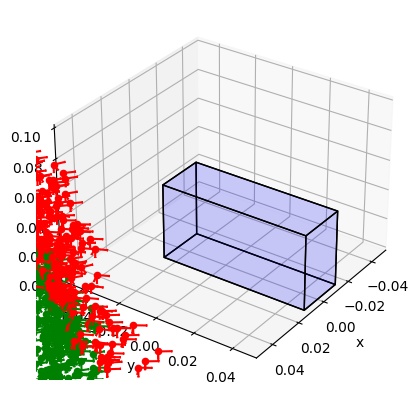

In [107]:
Z_PADDING = 0.15        # Adjust for visualisation of end poses

plot = plt.figure()
ax = plot.add_subplot(projection='3d')
ax.axes.set_xlim3d(-0.05, 0.05)
ax.axes.set_ylim3d(-0.05, 0.05)
ax.axes.set_zlim3d(0, 0.1)


# Plot hand poses with finger skeleton
for i in range(len(poses_data)):
    # Calculate approach vectors and cartesian coordinates
    pose = poses_data[i]
    x, y, z = pose[0], pose[1], pose[2]
    z -= Z_PADDING * 1.65
    av = calc_approach_vector(pose)
    # Color code the outcome
    outcome = grasp_outcomes_data[i]
    color = 'green' if outcome == 1 else 'red'
    for j in range(3):
        ax.quiver(x, y, z, av[j, 0], av[j, 1], av[j, 2], color=color, length=0.005, arrow_length_ratio=0.1)
    ax.scatter(x, y, z, color=color)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# Draw block object
def plot_cube(cube_definition, ax):
    cube_definition_array = [np.array(list(item)) for item in cube_definition]
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]
    points = np.array(points)
    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))
    ax.add_collection3d(faces)
    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)
    # ax.set_aspect('equal')
    
# Dimensions of the block object: (W=0.025, H=0.05, D=0.05)
# (0,0,0), (0,1,0), (1,0,0), (0,0,1) -> unit cube
cube_definition = [(-0.0125, -0.025, 0), (0.0125, -0.025, 0), (-0.0125, 0.05, 0), (-0.0125, -0.025, 0.05)]
plot_cube(cube_definition, ax)

# Display the plot at different angles
ax.view_init(elev=30, azim=35, roll=0)

If the green and red points are mixed up together, it proves that there is a problem when generating the random poses.

### 5. Model training

We now train our Logistic Regression models on the 3 combinations of our data (tactile, visual, both):
- Raw data
- Principal Component Analysis - 2 main components
- Convolutional Neural Network processed data

#### Prepare training and testing datasets

In [108]:
X_tactile_train, X_tactile_test, y_tactile_train, y_tactile_test = train_test_split(tactile_ds.reshape(tactile_ds.shape[0], -1), grasp_outcomes_data, test_size=0.2, random_state=0)
X_visual_train, X_visual_test, y_visual_train, y_visual_test = train_test_split(visual_ds, grasp_outcomes_data, test_size=0.2, random_state=0)
X_complete_train, X_complete_test, y_complete_train, y_complete_test = train_test_split(complete_ds, grasp_outcomes_data, test_size=0.2, random_state=0)

### 5.1 Raw data

#### 5.1.1 Raw data (tactile only) + LR

In [109]:
model_511 = LogisticRegression(random_state=0, max_iter=400)
model_511.fit(X_tactile_train, y_tactile_train)
model_511_predictions = model_511.predict(X_tactile_test)

#### 5.1.2 Raw data (visual only) + LR

In [110]:
model_512 = LogisticRegression(random_state=0, max_iter=400)
model_512.fit(X_visual_train, y_visual_train)
model_512_predictions = model_512.predict(X_visual_test)

#### 5.1.3 Raw data (both) + LR

In [111]:
model_513 = LogisticRegression(random_state=0, max_iter=400)
model_513.fit(X_complete_train, y_complete_train)
model_513_predictions = model_513.predict(X_complete_test)

### 5.2 PCA

There may not be enough memory to perform the PCA calculation on the entire input tensor. One solution to this issue is to perform PCA in a mini-batch fashion, where you break down the input tensor into smaller chunks and perform PCA on each chunk separately. Then, you can concatenate the results from each chunk to get the final result.

In [112]:
def pca_multid(tensor, k):
    tensor = tensor.reshape((tensor.shape[0], -1))
    pca = PCA(n_components=k)    
    pca.fit(tensor)
    return pca.transform(tensor)

def pca_2d(tensor, k):
    pca = PCA(n_components=k)    
    pca.fit(tensor)
    return pca.transform(tensor)

In [113]:
K = 3

pca_tactile_ds = torch.Tensor(np.array([pca_multid(i, k=3) for i in tactile_ds]))
pca_visual_ds = torch.Tensor(pca_2d(visual_ds, k=K))
pca_complete_ds = torch.Tensor(pca_2d(complete_ds, k=K))
pca_tactile_ds.shape, pca_visual_ds.shape, pca_complete_ds.shape

(torch.Size([800, 160, 3]), torch.Size([800, 3]), torch.Size([800, 3]))

In [114]:
X_pca_tactile_train, X_pca_tactile_test, y_pca_tactile_train, y_pca_tactile_test = train_test_split(pca_tactile_ds.reshape(pca_tactile_ds.shape[0], -1), grasp_outcomes_data, test_size=0.2, random_state=0)
X_pca_visual_train, X_pca_visual_test, y_pca_visual_train, y_pca_visual_test = train_test_split(pca_visual_ds, grasp_outcomes_data, test_size=0.2, random_state=0)
X_pca_complete_train, X_pca_complete_test, y_pca_complete_train, y_pca_complete_test = train_test_split(pca_complete_ds, grasp_outcomes_data, test_size=0.2, random_state=0)

#### 5.2.1 PCA (tactile only) + LR

In [115]:
model_521 = LogisticRegression(random_state=0, max_iter=400)
model_521.fit(X_pca_tactile_train, y_pca_tactile_train)
model_521_predictions = model_521.predict(X_pca_tactile_test)

d:\UCL_CS\Y3\COMP0029 Individual Project\Individual Project (90%)\UCL-FYP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 5.2.2 PCA (visual only) + LR

In [116]:
model_522 = LogisticRegression(random_state=0, max_iter=400)
model_522.fit(X_pca_visual_train, y_pca_visual_train)
model_522_predictions = model_522.predict(X_pca_visual_test)

#### 5.2.3 PCA (both) + LR

In [117]:
model_523 = LogisticRegression(random_state=0, max_iter=400)
model_523.fit(X_pca_complete_train, y_pca_complete_train)
model_523_predictions = model_523.predict(X_pca_complete_test)

### 5.3 CNN for dimensionality reduction

In [132]:
# A simple convolutional neural network that extracts features from an input tensor
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=3)


    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        return x

In [133]:
# Preprocess data using CNN feature extraction
cnn = FeatureExtractorCNN()
cnn_tactile = torch.cat([cnn(img.float().permute(2,0,1)).unsqueeze(0) for img in tactile_ds])
cnn_tactile = cnn_tactile.reshape(cnn_tactile.shape[0], -1)
cnn_tactile.shape

torch.Size([800, 512])

In [134]:
# We simply combine the cnn-processed tactile data (from Section 5.3.1) with the visual data
cnn_complete_ds = torch.cat([cnn_tactile.reshape(cnn_tactile.shape[0], -1), visual_ds], dim=1)
cnn_complete_ds.shape

torch.Size([800, 518])

In [135]:
X_cnn_tactile_train, X_cnn_tactile_test, y_cnn_tactile_train, y_cnn_tactile_test = train_test_split(cnn_tactile.detach().numpy(), grasp_outcomes_data, test_size=0.2, random_state=0)
X_cnn_complete_train, X_cnn_complete_test, y_cnn_complete_train, y_cnn_complete_test = train_test_split(cnn_complete_ds.detach().numpy(), grasp_outcomes_data, test_size=0.2, random_state=0)

#### 5.3.1 CNN (tactile only) + LR

In [136]:
model_531 = LogisticRegression(random_state=0, max_iter=400)
model_531.fit(X_cnn_tactile_train, y_cnn_tactile_train)
model_531_predictions = model_531.predict(X_cnn_tactile_test)

#### 5.3.2 CNN (visual only) + LR

#### 5.3.3 CNN (both) + LR

In [137]:
model_533 = LogisticRegression(random_state=0, max_iter=400)
model_533.fit(X_cnn_complete_train, y_cnn_complete_train)
model_533_predictions = model_533.predict(X_cnn_complete_test)

### 5.4 Results

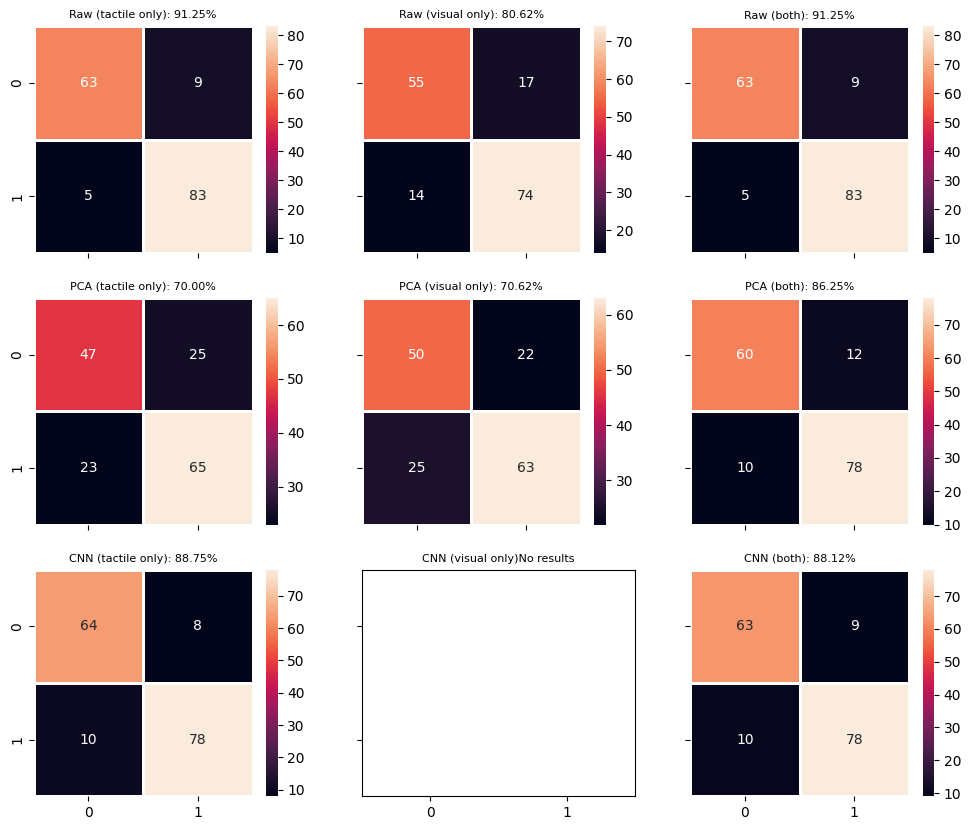

In [138]:
import seaborn as sns

model_data = {
    "Raw (tactile only)": {"score": model_511.score(X_tactile_test, y_tactile_test), "preds": model_511_predictions, "test_set": y_tactile_test},
    "Raw (visual only)": {"score": model_512.score(X_visual_test, y_visual_test), "preds": model_512_predictions, "test_set": y_visual_test},
    "Raw (both)": {"score": model_513.score(X_complete_test, y_complete_test),"preds": model_513_predictions,"test_set": y_complete_test},
    "PCA (tactile only)": {"score": model_521.score(X_pca_tactile_test, y_pca_tactile_test),"preds": model_521_predictions,"test_set": y_pca_tactile_test},
    "PCA (visual only)": {"score": model_522.score(X_pca_visual_test, y_pca_visual_test),"preds": model_522_predictions,"test_set": y_pca_visual_test},
    "PCA (both)": {"score": model_523.score(X_pca_complete_test, y_pca_complete_test),"preds": model_523_predictions,"test_set": y_pca_complete_test},
    "CNN (tactile only)": {"score": model_531.score(X_cnn_tactile_test, y_cnn_tactile_test), "preds": model_531_predictions,"test_set": y_cnn_tactile_test},
    "CNN (visual only)": {"score": None, "preds": None, "test_set": None},
    "CNN (both)": {"score": model_533.score(X_cnn_complete_test, y_cnn_complete_test), "preds": model_533_predictions, "test_set":y_cnn_complete_test}
}

fig, axn = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,10))

for i, ax in enumerate(axn.flat):
    model_name = list(model_data.keys())[i]
    model = model_data[model_name]
    preds = model["preds"]
    score = model["score"]
    test_set = model["test_set"]

    if score is not None and preds is not None and test_set is not None:
        cm = confusion_matrix(test_set, preds)
        sns.heatmap(cm, linewidths=1, ax=ax, annot=True, fmt='g')
        ax.set_title(model_name + f": {score*100:.2f}%", fontsize=8)
    else:
        ax.set_title(model_name + "No results", fontsize=8)
    continue